0.284735340523
-0.718402681962


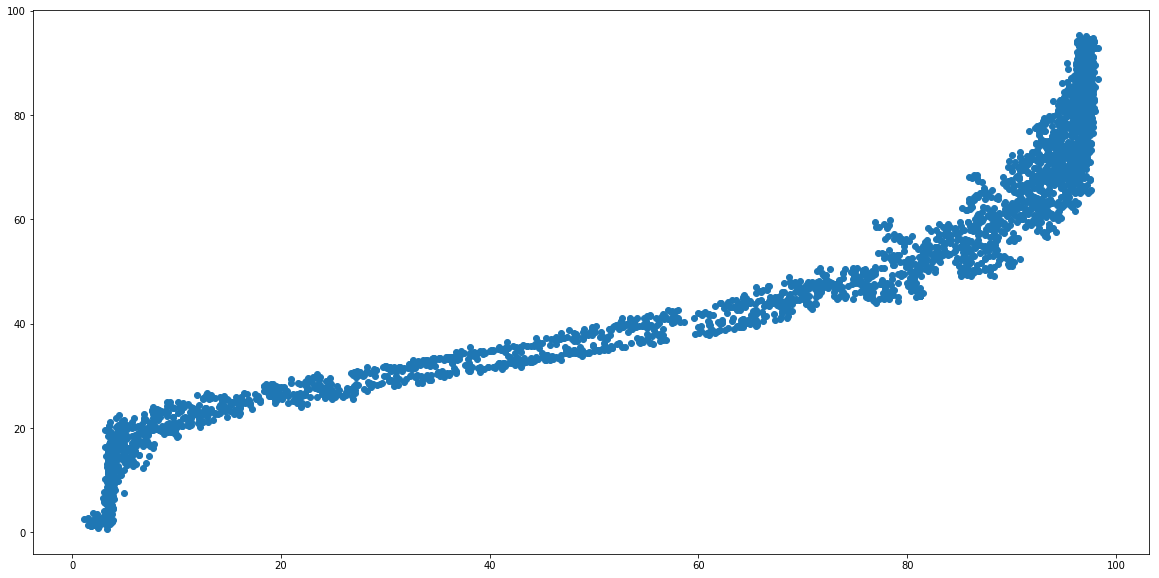

1.6017685411 -0.595547662388 -0.907660503395
1.3015149729 -0.239685807137 -1.44520532949
1.9504010067 -0.053209957174 -1.04857119785
1.45138329156 0.0997114057572 -1.54947747382
1.65585799157 0.360286242564 -1.27276213567
1.61438969903 0.12547011691 -0.577118873696
1.58747492135 0.31240902499 -1.49071632911
1.36741213913 -0.171180132062 -1.58710846613
2.54927776642 0.526185475922 -0.901097079141
1.40518055253 0.130978566061 -0.892270613855
1.45454771063 -0.222037014155 -0.451285854787
1.41826611737 0.255934052877 -1.59174294463
----------------------------------------------------
19.3574747103 3.092635458 -13.7150168016


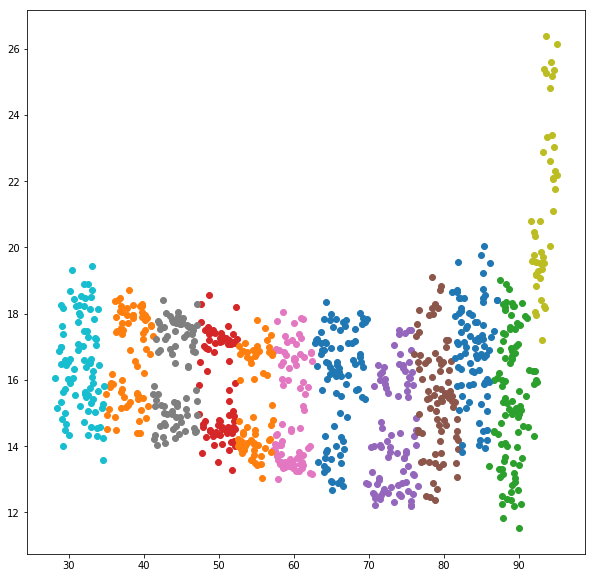

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.cluster import DBSCAN, KMeans

data_set = pd.read_csv('./data/ScatterData_Burgula_B-547.csv')

# Algorithm Object
alg = DBSCAN(eps=1, min_samples=8)
alg_km = KMeans(n_clusters=12)

# Filter Data
data_set = data_set[data_set['TurbineState'] == 100]
data_set = data_set[data_set['ActivePower'] > 0]
data_set = data_set[data_set['RotorSpeed'] > 20]

# Scale Data
AP_min = data_set['ActivePower'].min()
RS_min = data_set['RotorSpeed'].min()
AP_max = data_set['ActivePower'].max()
RS_max = data_set['RotorSpeed'].max()

data_set['s_AP'] = ((data_set['ActivePower'] - AP_min) * 100) / (AP_max - AP_min)
data_set['s_RS'] = ((data_set['RotorSpeed'] - RS_min) * 100) / (RS_max - RS_min)

# Vars
bucket_size =  10

# Fit alg
data_set['dbscan_label'] = alg.fit_predict(data_set[['s_RS', 's_AP']])
data_set = data_set[data_set['dbscan_label'] != -1]

# Make Clusters and add em up
crop_data = data_set[(data_set['s_RS'] > 20) & (data_set['s_RS'] < 80)].copy()
crop_data['km_label'] = alg_km.fit_predict(crop_data[['s_RS', 's_AP']])


# Print stats
print ss.skew(data_set[(data_set['s_RS'] > 20) & (data_set['s_RS'] < 80)]['s_AP'])
print ss.kurtosis(data_set[(data_set['s_RS'] > 20) & (data_set['s_RS'] < 80)]['s_AP'])

# Plot Data
plt.figure(figsize=(20, 10))
plt.scatter(data_set['s_RS'], data_set['s_AP'])
plt.show()

# Rotate
theta = 22
rot_mat = np.array([
    [np.cos((np.pi * theta) / 180), -np.sin((np.pi * theta) / 180)],
    [np.sin((np.pi * theta) / 180), np.cos((np.pi * theta) / 180)]
])
crop_data['rot_RS'] = 0
crop_data['rot_AP'] = 0
crop_data[['rot_RS', 'rot_AP']] = np.dot(crop_data[['s_RS', 's_AP']], rot_mat)


# Plot Data
total_std = 0
total_sk = 0
total_kurt = 0
plt.figure(figsize=(10, 10))
for g in crop_data.groupby('km_label'):
    print  np.std(g[1]['rot_AP']), ss.skew(g[1]['rot_AP']), ss.kurtosis(g[1]['rot_AP'])
    total_std = total_std + np.std(g[1]['rot_AP'])
    total_sk = total_sk + np.abs(ss.skew(g[1]['rot_AP']))
    total_kurt = total_kurt + ss.kurtosis(g[1]['rot_AP'])
    plt.scatter(g[1]['rot_RS'], g[1]['rot_AP'])
print '----------------------------------------------------'
print total_std, total_sk, total_kurt
plt.show()